In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-10-04 07:17:54.274083: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 07:17:54.274669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 07:17:54.278388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 07:17:54.289134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 07:17:54.309157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# 各パス指定

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# 分類数設定

In [3]:
NUM_CLASSES = 3

# 入力長

In [4]:
TIME_STEPS = 16
DIMENSION = 4

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

/home/rafaella/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843 (7.20 KB)

 Trainable params: 1,843 (7.20 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


27/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4690 - loss: 1.0926 
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5048 - loss: 1.0832 - val_accuracy: 0.6392 - val_loss: 1.0144
Epoch 2/1000
49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6134 - loss: 1.0028
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6162 - loss: 0.9953 - val_accuracy: 0.6812 - val_loss: 0.8830
Epoch 3/1000
46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 0.8782
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6582 - loss: 0.8735 - val_accuracy: 0.6890 - val_loss: 0.7887
Epoch 4/1000
38/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.8074 
Epoch 4: saving model to model/point_history_classifier/point

In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0.71666896 0.01948169 0.26384938]
0


# 混同行列

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


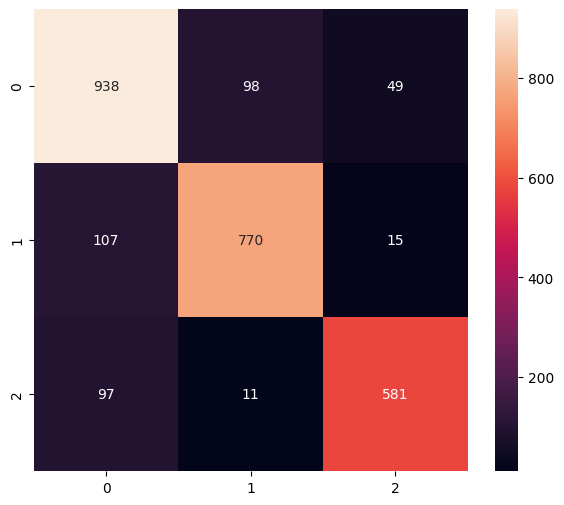

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1085
           1       0.88      0.86      0.87       892
           2       0.90      0.84      0.87       689

    accuracy                           0.86      2666
   macro avg       0.87      0.86      0.86      2666
weighted avg       0.86      0.86      0.86      2666



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [17]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [18]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpb_zjra29/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_zjra29/assets


Saved artifact at '/tmp/tmpb_zjra29'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140412232730400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140412232734800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140412232741664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140412232743952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140412232877152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140412232879968: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1728037122.286656   37840 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728037122.286739   37840 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-04 07:18:42.287819: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb_zjra29
2024-10-04 07:18:42.288642: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-04 07:18:42.288660: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpb_zjra29
2024-10-04 07:18:42.292544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-04 07:18:42.293322: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-04 07:18:42.328766: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpb_zjra29
2024-10-04 07:18:42.343522: I tensorflow/cc/saved_model/loader.cc

5224

# 推論テスト

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 64], dtype=int32), 'shape_signature': array([-1, 64], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 456 µs, sys: 36 µs, total: 492 µs
Wall time: 1.53 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.7149477  0.01940456 0.2656478 ]
0
